<a id="top"></a>
# NIRISS AMI calibration of binary point source AB-Dor and calibrator HD37093

***

## Imports
Describe the libraries we're using here. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *matplotlib.pyplot* for plotting data
- *zipfile* for accessing zip file
- *urllib.request* to access URL
- *jwst.pipeline Detector1Pipeline, Image2Pipeline* for calibrating raw data

In [27]:
%matplotlib inline
import os
import sys
import glob
import time

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

from jwst.pipeline.collect_pipeline_cfgs import collect_pipeline_cfgs
from jwst.pipeline import Detector1Pipeline, Image2Pipeline

## Introduction
This script runs JWST pipeline on AMI data simulated with Mirage.

Steps:

[1] Run Detector1 pipeline on all _uncal.fits files to create _rate.fits and _rateints.fits files.

[2] Run Image2 pipeline on all _rate.fits files to create _cal.fits and on _rateints.fits files to
   create _calints.fits files.

 
[3] Run ImPlaneIA to extract observables in oifits format     

## Loading data
Upload simulated data created by 1_niriss_ami_binary.ipynb and required reference files to calibrate data without bad pixels.

In [28]:
boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/niriss_ami_binary/niriss_ami_binary2.zip'
boxfile = './niriss_ami_binary2.zip'

# Download zip file
if not os.path.exists(boxfile):
    urllib.request.urlretrieve(boxlink, boxfile)
    
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()

In [29]:
#Define directory that has existing Mirage simulations
currentdir = os.getcwd()
mirage_sim_dir = os.path.join(currentdir, 'mirage_sim_data/')
print(mirage_sim_dir)
datafiles = sorted(glob.glob(mirage_sim_dir + 'jw*uncal.fits'))
print(datafiles)

/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/
['/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits', '/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits']


## Examine the input raw files

2020-09-17 15:44:05,241 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:3: ResourceWarning: unclosed file <_io.FileIO name='/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits' mode='rb' closefd=True>
  This is separate from the ipykernel package so we can avoid doing imports until



Filename: /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     125   ()      
  1  SCI           1 ImageHDU        50   (80, 80, 5, 65)   int16 (rescales to uint16)   
  2  ZEROFRAME     1 ImageHDU        12   (80, 80, 65)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableHDU     36   325R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  4  INT_TIMES     1 BinTableHDU     24   65R x 7C   [J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [4455B]   


2020-09-17 15:44:05,267 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:3: ResourceWarning: unclosed file <_io.FileIO name='/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits' mode='rb' closefd=True>
  This is separate from the ipykernel package so we can avoid doing imports until



(5, 80, 80)
Filename: /Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     125   ()      
  1  SCI           1 ImageHDU        50   (80, 80, 12, 60)   int16 (rescales to uint16)   
  2  ZEROFRAME     1 ImageHDU        12   (80, 80, 60)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableHDU     36   720R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  4  INT_TIMES     1 BinTableHDU     24   60R x 7C   [J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [4476B]   
(12, 80, 80)
(5, 80, 80) (12, 80, 80)


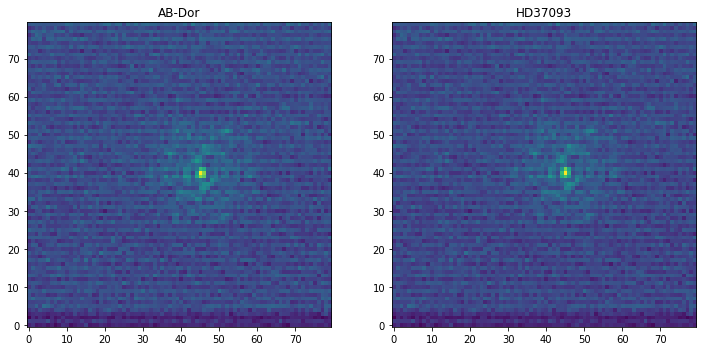

In [30]:
data = []
for i, df in enumerate(datafiles):
    file = fits.open(df)
    file.info()
    im = file[1].data    
    print(im[0].shape)
    data.append(im[0])
print(data[0].shape, data[1].shape)
f = plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("AB-Dor")
plt.imshow(data[0][4], origin='lower')
plt.subplot(1, 2, 2)
plt.title("HD37093")
plt.imshow(data[1][11], origin='lower')

## Define output directory and non-default reference files directory

Note that we will not use the cfgfiles but update the steps and override reference files using the .run() method.

In [34]:
#Define output directory to save pipeline output products and default configuration files.
odir = './pipeline_calibrated_data/'
if not os.path.exists(odir):
    os.mkdir(odir)

# Define path to non-default referencde file.
# We are using these files to calibrate data that is simukated without bad pixels.
refdir = './ref_files_non_default/'

#os.environ['CRDS_PATH']='$HOME/crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'
os.environ['CRDS_CONTEXT'] ='jwst_0616.pmap'

## Run Detector1 and Image2 pipelines

In [35]:
datafiles = sorted(glob.glob(mirage_sim_dir + 'jw*uncal.fits'))
print(datafiles)
for df in datafiles:
#Run Detector1, Image 2 pipelines
    result1 = Detector1Pipeline()
    superbiasfile = refdir + 'jwst_niriss_superbias_sim.fits'
    darkfile = refdir + 'jwst_niriss_dark_sub80_sim.fits'
    result1.superbias.override_superbias = superbiasfile
    result1.dark_current.override_dark = darkfile
    result1.ipc.skip = True
    result1.save_results = True
    result1.output_dir = odir
    result1.run(df)
                
    df_rate = odir + os.path.basename(df.replace('uncal','rate'))
    flatfieldfile = refdir + "jwst_niriss_flat_general.fits"
    result2 = Image2Pipeline()        
    result2.flat_field.override_flat = flatfieldfile
    result2.photom.skip = True
    result2.resample.skip = True
    result2.save_results = True
    result2.output_dir = odir
    result2.run(df_rate)

    df_rateints = odir + os.path.basename(df.replace('uncal','rateints'))
    result3 = Image2Pipeline()
    result3.flat_field.override_flat = flatfieldfile
    result3.photom.skip = True
    result3.resample.skip = True
    result3.save_results = True
    result3.output_dir = odir
    result3.run(df_rateints)   
        

2020-09-17 16:07:44,725 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2020-09-17 16:07:44,727 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2020-09-17 16:07:44,728 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2020-09-17 16:07:44,731 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2020-09-17 16:07:44,732 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2020-09-17 16:07:44,734 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2020-09-17 16:07:44,736 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2020-09-17 16:07:44,738 - stpipe.Detector1Pipeline.rscd - INFO - RSCD_Step instance created.
2020-09-17 16:07:44,740 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2020-09-17 16:07:44,741 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2020-09-17 

['/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093001001_01101_00001_nis_uncal.fits', '/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data/jw01093002001_01101_00001_nis_uncal.fits']


2020-09-17 16:07:44,975 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01093001001_01101_00001_nis_uncal.fits' reftypes = ['gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'rscd', 'saturation', 'trapdensity', 'trappars']
2020-09-17 16:07:45,340 - stpipe.Detector1Pipeline - INFO - Override for DARK reference file is '/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/ref_files_non_default/jwst_niriss_dark_sub80_sim.fits'.
2020-09-17 16:07:45,342 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0005.fits'.
2020-09-17 16:07:45,389 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0011.fits'.
2020-09-17 16:07:45,431 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0013.fits'.
2020-09-17 16:07:45,478 - s

2020-09-17 16:07:47,534 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2020-09-17 16:07:47,534 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2020-09-17 16:07:48,840 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2020-09-17 16:07:48,976 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(65, 5, 80, 80) from jw01093001001_01101_00001_nis_uncal.fits>,).
2020-09-17 16:07:48,980 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data'}
2020-09-17 16:07:49,022 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/refere

2020-09-17 16:08:09,738 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 15
2020-09-17 16:08:09,741 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 420 pixels with at least one CR
2020-09-17 16:08:09,758 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 16
2020-09-17 16:08:09,760 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 410 pixels with at least one CR
2020-09-17 16:08:09,784 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 17
2020-09-17 16:08:09,787 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 404 pixels with at least one CR
2020-09-17 16:08:09,810 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 18
2020-09-17 16:08:09,813 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 402 pixels with at least one CR
2020-09-17 16:08:09,836 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 19
2020

2020-09-17 16:08:10,514 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 400 pixels with at least one CR
2020-09-17 16:08:10,532 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 52
2020-09-17 16:08:10,534 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 404 pixels with at least one CR
2020-09-17 16:08:10,549 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 53
2020-09-17 16:08:10,552 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 413 pixels with at least one CR
2020-09-17 16:08:10,574 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 54
2020-09-17 16:08:10,576 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 409 pixels with at least one CR
2020-09-17 16:08:10,599 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 55
2020-09-17 16:08:10,602 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point 

2020-09-17 16:08:14,056 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2020-09-17 16:08:14,122 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./pipeline_calibrated_data/jw01093001001_01101_00001_nis_rate.fits',).
2020-09-17 16:08:14,131 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './pipeline_calibrated_data/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'po

2020-09-17 16:08:15,804 - stpipe.Image2Pipeline.photom - INFO - Step skipped.
2020-09-17 16:08:15,807 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2020-09-17 16:08:15,877 - stpipe.Image2Pipeline - INFO - Finished processing product ./pipeline_calibrated_data/jw01093001001_01101_00001_nis
2020-09-17 16:08:15,879 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2
2020-09-17 16:08:15,955 - stpipe.Image2Pipeline - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/gwcs/wcs.py:131: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transforms = np.array(self._pipeline[from_ind: to_ind])[:, 1].copy()

2020-09-17 16:08:16,042 - stpipe.Image2Pipeline - INFO - Saved model in ./pipeline_calibrated_data/jw01093001001_01101_00001_nis_

2020-09-17 16:08:17,364 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2020-09-17 16:08:17,369 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2020-09-17 16:08:17,510 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<CubeModel(65, 80, 80) from jw01093001001_01101_00001_nis_rateints.fits>,).
2020-09-17 16:08:17,513 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': './pipeline_calibrated_data', 'save_interpolated_flat': False}
2020-09-17 16:08:17,616 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_INTERNAL_FLAT does not correspond to an existing DQ mnemonic, so will be ignored
2020-09-17 16:08:17,718 - stpipe.Image2Pipeline.flat_field - INFO - 

2020-09-17 16:08:18,530 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01093002001_01101_00001_nis_uncal.fits' reftypes = ['gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'rscd', 'saturation', 'trapdensity', 'trappars']
2020-09-17 16:08:18,533 - stpipe.Detector1Pipeline - INFO - Override for DARK reference file is '/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/ref_files_non_default/jwst_niriss_dark_sub80_sim.fits'.
2020-09-17 16:08:18,534 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_niriss_gain_0005.fits'.
2020-09-17 16:08:18,562 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_niriss_linearity_0011.fits'.
2020-09-17 16:08:18,590 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_niriss_mask_0013.fits'.
2020-09-17 16:08:18,620 - s

2020-09-17 16:08:20,582 - stpipe.Detector1Pipeline.refpix - INFO - side_gain = 1.000000
2020-09-17 16:08:20,582 - stpipe.Detector1Pipeline.refpix - INFO - odd_even_rows = True
2020-09-17 16:08:23,001 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done
2020-09-17 16:08:23,146 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(60, 12, 80, 80) from jw01093002001_01101_00001_nis_uncal.fits>,).
2020-09-17 16:08:23,149 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/thatte/niriss/dat_pyinthesky/jdat_notebooks/niriss_ami_binary/mirage_sim_data'}
2020-09-17 16:08:23,189 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/refer

2020-09-17 16:08:55,486 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 15
2020-09-17 16:08:55,490 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 340 pixels with at least one CR
2020-09-17 16:08:55,509 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 16
2020-09-17 16:08:55,513 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 338 pixels with at least one CR
2020-09-17 16:08:55,532 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 17
2020-09-17 16:08:55,535 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 342 pixels with at least one CR
2020-09-17 16:08:55,550 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 18
2020-09-17 16:08:55,554 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 356 pixels with at least one CR
2020-09-17 16:08:55,573 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 19
2020

2020-09-17 16:08:56,250 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 51
2020-09-17 16:08:56,254 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 341 pixels with at least one CR
2020-09-17 16:08:56,273 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 52
2020-09-17 16:08:56,277 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 349 pixels with at least one CR
2020-09-17 16:08:56,290 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 53
2020-09-17 16:08:56,294 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 337 pixels with at least one CR
2020-09-17 16:08:56,313 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 54
2020-09-17 16:08:56,317 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two point found 372 pixels with at least one CR
2020-09-17 16:08:56,337 - stpipe.Detector1Pipeline.jump - INFO -  working on integration 55
2020

2020-09-17 16:09:00,321 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01093002001_01101_00001_nis_rate.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2020-09-17 16:09:00,348 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2020-09-17 16:09:00,349 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2020-09-17 16:09:00,350 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2020-09-17 16:09:00,351 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2020-09-17 16:09:00,351 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_distortion_0010.asdf'.
2020-09-17 16:09:00,377 - stpipe.Image2Pipeline - INFO - 

2020-09-17 16:09:02,310 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'jw01093002001_01101_00001_nis_rateints.fits' reftypes = ['camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']
2020-09-17 16:09:02,338 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.
2020-09-17 16:09:02,339 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.
2020-09-17 16:09:02,340 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.
2020-09-17 16:09:02,341 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.
2020-09-17 16:09:02,342 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_niriss_distortion_0010.asdf'.
2020-09-17 16:09:02,366 - stpipe.Image2Pipeline - INF

## Examine the output files

In [40]:
ratefiles = sorted(glob.glob(odir + 'jw*rate.fits'))
print(ratefiles)
rateintsfiles = sorted(glob.glob(odir + 'jw*rateints.fits'))
print(rateintsfiles)
calfiles = sorted(glob.glob(odir + 'jw*cal.fits'))
print(calfiles)
calintsfiles = sorted(glob.glob(odir + 'jw*calints.fits'))
print(calintsfiles)

['./pipeline_calibrated_data/jw01093001001_01101_00001_nis_rate.fits', './pipeline_calibrated_data/jw01093002001_01101_00001_nis_rate.fits']
['./pipeline_calibrated_data/jw01093001001_01101_00001_nis_rateints.fits', './pipeline_calibrated_data/jw01093002001_01101_00001_nis_rateints.fits']
['./pipeline_calibrated_data/jw01093001001_01101_00001_nis_cal.fits', './pipeline_calibrated_data/jw01093002001_01101_00001_nis_cal.fits']
['./pipeline_calibrated_data/jw01093001001_01101_00001_nis_calints.fits', './pipeline_calibrated_data/jw01093002001_01101_00001_nis_calints.fits']


### rate and rateints files

In [43]:
for i, rateintf in enumerate(rateintsfiles):
    file = fits.open(rateintf)
    file.info()
for i, ratef in enumerate(ratefiles):
    file = fits.open(ratef)
    file.info()

2020-09-17 16:16:14,837 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='./pipeline_calibrated_data/jw01093002001_01101_00001_nis_rateints.fits' mode='rb' closefd=True>
  



Filename: ./pipeline_calibrated_data/jw01093001001_01101_00001_nis_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   ()      
  1  SCI           1 ImageHDU        48   (80, 80, 65)   float32   
  2  ERR           1 ImageHDU        11   (80, 80, 65)   float32   
  3  DQ            1 ImageHDU        12   (80, 80, 65)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (80, 80, 65)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (80, 80, 65)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [5620B]   


2020-09-17 16:16:14,849 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='./pipeline_calibrated_data/jw01093001001_01101_00001_nis_rateints.fits' mode='rb' closefd=True>
  



Filename: ./pipeline_calibrated_data/jw01093002001_01101_00001_nis_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   ()      
  1  SCI           1 ImageHDU        48   (80, 80, 60)   float32   
  2  ERR           1 ImageHDU        11   (80, 80, 60)   float32   
  3  DQ            1 ImageHDU        12   (80, 80, 60)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (80, 80, 60)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (80, 80, 60)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [5669B]   


2020-09-17 16:16:14,861 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.FileIO name='./pipeline_calibrated_data/jw01093002001_01101_00001_nis_rateints.fits' mode='rb' closefd=True>
  """



Filename: ./pipeline_calibrated_data/jw01093001001_01101_00001_nis_rate.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   ()      
  1  SCI           1 ImageHDU        47   (80, 80)   float32   
  2  ERR           1 ImageHDU        10   (80, 80)   float32   
  3  DQ            1 ImageHDU        11   (80, 80)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (80, 80)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (80, 80)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [5030B]   


2020-09-17 16:16:14,871 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.FileIO name='./pipeline_calibrated_data/jw01093001001_01101_00001_nis_rate.fits' mode='rb' closefd=True>
  """



Filename: ./pipeline_calibrated_data/jw01093002001_01101_00001_nis_rate.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     165   ()      
  1  SCI           1 ImageHDU        47   (80, 80)   float32   
  2  ERR           1 ImageHDU        10   (80, 80)   float32   
  3  DQ            1 ImageHDU        11   (80, 80)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (80, 80)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (80, 80)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [5079B]   


### cal and calints files 

In [44]:
for i, calintf in enumerate(calintsfiles):
    file = fits.open(calintf)
    file.info()
for i, calf in enumerate(calfiles):
    file = fits.open(calf)
    file.info()

2020-09-17 16:17:52,365 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='./pipeline_calibrated_data/jw01093002001_01101_00001_nis_rate.fits' mode='rb' closefd=True>
  



Filename: ./pipeline_calibrated_data/jw01093001001_01101_00001_nis_calints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     248   ()      
  1  SCI           1 ImageHDU        49   (80, 80, 65)   float32   
  2  ERR           1 ImageHDU        11   (80, 80, 65)   float32   
  3  DQ            1 ImageHDU        12   (80, 80, 65)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (80, 80, 65)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (80, 80, 65)   float32   
  7  VAR_FLAT      1 ImageHDU        10   (80, 80, 65)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [14976B]   


2020-09-17 16:17:52,382 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:2: ResourceWarning: unclosed file <_io.FileIO name='./pipeline_calibrated_data/jw01093001001_01101_00001_nis_calints.fits' mode='rb' closefd=True>
  



Filename: ./pipeline_calibrated_data/jw01093002001_01101_00001_nis_calints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     248   ()      
  1  SCI           1 ImageHDU        49   (80, 80, 60)   float32   
  2  ERR           1 ImageHDU        11   (80, 80, 60)   float32   
  3  DQ            1 ImageHDU        12   (80, 80, 60)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (80, 80, 60)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (80, 80, 60)   float32   
  7  VAR_FLAT      1 ImageHDU        10   (80, 80, 60)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [15025B]   


2020-09-17 16:17:52,397 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.FileIO name='./pipeline_calibrated_data/jw01093002001_01101_00001_nis_calints.fits' mode='rb' closefd=True>
  """



Filename: ./pipeline_calibrated_data/jw01093001001_01101_00001_nis_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     248   ()      
  1  SCI           1 ImageHDU        48   (80, 80)   float32   
  2  ERR           1 ImageHDU        10   (80, 80)   float32   
  3  DQ            1 ImageHDU        11   (80, 80)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (80, 80)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (80, 80)   float32   
  6  VAR_FLAT      1 ImageHDU         9   (80, 80)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [14403B]   


2020-09-17 16:17:52,411 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:5: ResourceWarning: unclosed file <_io.FileIO name='./pipeline_calibrated_data/jw01093001001_01101_00001_nis_cal.fits' mode='rb' closefd=True>
  """



Filename: ./pipeline_calibrated_data/jw01093002001_01101_00001_nis_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     248   ()      
  1  SCI           1 ImageHDU        48   (80, 80)   float32   
  2  ERR           1 ImageHDU        10   (80, 80)   float32   
  3  DQ            1 ImageHDU        11   (80, 80)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (80, 80)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (80, 80)   float32   
  6  VAR_FLAT      1 ImageHDU         9   (80, 80)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [14452B]   


## Display calibrated data

2020-09-17 16:30:10,105 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:3: ResourceWarning: unclosed file <_io.FileIO name='./pipeline_calibrated_data/jw01093002001_01101_00001_nis_cal.fits' mode='rb' closefd=True>
  This is separate from the ipykernel package so we can avoid doing imports until

2020-09-17 16:30:10,114 - stpipe - WARNING - /Users/thatte/anaconda3/envs/mirage_08052020/lib/python3.6/site-packages/ipykernel_launcher.py:3: ResourceWarning: unclosed file <_io.FileIO name='./pipeline_calibrated_data/jw01093001001_01101_00001_nis_cal.fits' mode='rb' closefd=True>
  This is separate from the ipykernel package so we can avoid doing imports until



(80, 80)
(80, 80)


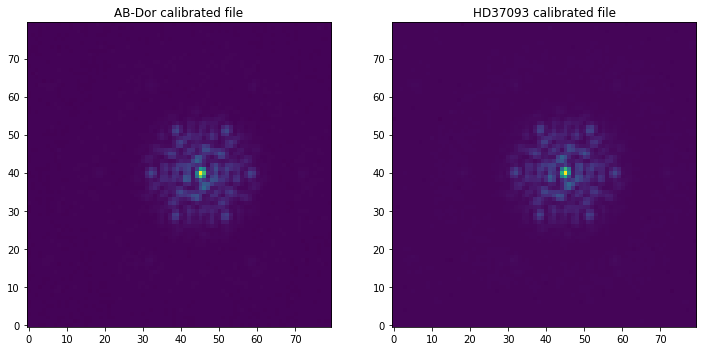

In [47]:
data = []
for df in calfiles:
    file = fits.open(df)
    im = file[1].data    
    print(im.shape)
    data.append(im)
#print(data[0].shape, data[1].shape)
f = plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("AB-Dor 2D calibrated file")
plt.imshow(data[0], origin='lower')
plt.subplot(1, 2, 2)
plt.title("HD37093 2D calibrated file")
plt.imshow(data[1], origin='lower')

## File information

Explain pertinent details about the file you've just downloaded. For example, if working with Kepler lightcurves, explain what's in the different file extensions:

```
- No. 0 (Primary): This HDU contains meta-data related to the entire file.
- No. 1 (Light curve): This HDU contains a binary table that holds data like flux measurements and times. We will extract information from here when we define the parameters for the light curve plot.
- No. 2 (Aperture): This HDU contains the image extension with data collected from the aperture. We will also use this to display a bitmask plot that visually represents the optimal aperture used to create the SAP_FLUX column in HDU1.
```

## Aditional Resources
Placeholder

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [Exo.MAST website](https://exo.mast.stsci.edu/exo/ExoMast/html/exomast.html)

## About this notebook

**Author:** Deepashri Thatte, Staff Scientist II, Rachel Cooper,
**Updated On:** 2020-09-17

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 